# Region based "1D" analysis using MapDataset
 
This notebook outlines the use of the `MapDataset` for 1D spectral analysis as well. This becomes possible by relying on the `RegionGeom` for the analysis.. It shows that the results and performance are equivalent between the current and new approach. The advantages are:
- Reduced code duplication
- Containment correction for arbitrary region shapes and spatial models
- Correction of "contamination" by other sources
- 100% API uniformity between 1D and 3D analysis
- Keeping PSF meta information on the spectrum dataset


In [1]:
import numpy as np
from gammapy.data import DataStore
from gammapy.datasets import SpectrumDataset, MapDataset, Datasets
from gammapy.makers import SpectrumDatasetMaker, MapDatasetMaker
from gammapy.maps import RegionGeom, MapAxis
from gammapy.modeling.models import SkyModel, PowerLawSpectralModel, PointSpatialModel, GaussianSpatialModel
from gammapy.modeling import Fit
from astropy import units as u

import matplotlib.pyplot as plt

In [2]:
datastore = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1/")
obs_ids = [23523, 23526, 23559, 23592]
observations = datastore.get_observations(obs_ids)

In [3]:
energy_axis = MapAxis.from_energy_bounds(0.1, 40, 40, unit="TeV", name="energy")
energy_axis_true = MapAxis.from_energy_bounds(
    0.05, 100, 10, unit="TeV", name="energy_true", per_decade=True
)

geom = RegionGeom.create("icrs;circle(83.63, 22.01, 0.11)", axes=[energy_axis])

In [4]:
reference = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true
)
reference_spec = SpectrumDataset.create(
    geom=geom, energy_axis_true=energy_axis_true
)

In [5]:
maker = MapDatasetMaker()
maker_spec = SpectrumDatasetMaker(containment_correction=True)

In [6]:
%%time

# runtime is a ~10-20% longer as a `PSFMap` is computed as well
datasets = Datasets()

for obs in observations:
    dataset = maker.run(reference.copy(), obs)
    datasets.append(dataset)

CPU times: user 1.44 s, sys: 56.7 ms, total: 1.5 s
Wall time: 1.61 s


In [7]:
%%time
datasets_spec = Datasets()

for obs in observations:
    dataset_spec = maker_spec.run(reference_spec.copy(), obs)
    datasets_spec.append(dataset_spec)

CPU times: user 1.2 s, sys: 34.5 ms, total: 1.24 s
Wall time: 1.27 s


In [8]:
spectral_model = PowerLawSpectralModel(
    index=2, amplitude=2e-11 * u.Unit("cm-2 s-1 TeV-1"), reference=1 * u.TeV
)

# for the containment correction in the MapDataset it is now needed to define a frozen spatial model
spatial_model = PointSpatialModel(lon_0="83.63 deg", lat_0="22.01 deg")
spatial_model.freeze()

model_ref = SkyModel(
    spectral_model=spectral_model,
    spatial_model=spatial_model,
    name="crab")

In [9]:
model = model_ref.copy("crab")
datasets.models = [model]

In [10]:
fit = Fit(datasets, store_trace=True)

In [11]:
%%time
result = fit.run()

CPU times: user 427 ms, sys: 7.41 ms, total: 434 ms
Wall time: 438 ms


In [12]:
print(result)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 35
	total stat : -1858.41



In [13]:
print(model)

SkyModel

  Name                      : crab
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :   2.738              
    amplitude               :   4.64e-11  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
    lon_0        (frozen)   :  83.630  deg         
    lat_0        (frozen)   :  22.010  deg         




In [14]:
model_spec = model_ref.copy(name="crab")
model_spec.spatial_model = None
datasets_spec.models = [model_spec]
fit_spec = Fit(datasets_spec, store_trace=True)

In [15]:
%%time
result_spec = fit_spec.run()

CPU times: user 369 ms, sys: 8.01 ms, total: 377 ms
Wall time: 397 ms


In [16]:
print(result_spec)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 35
	total stat : -1858.47



<AxesSubplot:xlabel='Energy [TeV]', ylabel='Flux [1 / (cm2 s TeV)]'>

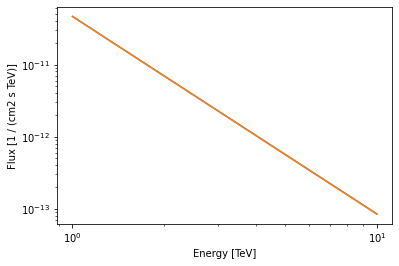

In [17]:
model.spectral_model.plot(energy_range=[1, 10] * u.TeV)
model_spec.spectral_model.plot(energy_range=[1, 10] * u.TeV)

In [18]:
print(model)

SkyModel

  Name                      : crab
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :   2.738              
    amplitude               :   4.64e-11  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
    lon_0        (frozen)   :  83.630  deg         
    lat_0        (frozen)   :  22.010  deg         




In [19]:
print(model_spec)

SkyModel

  Name                      : crab
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    index                   :   2.740              
    amplitude               :   4.63e-11  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         




## Mutiple models 1D vs 3D

This section compares the predicted counts in agiven region from a fill 3D model and a 1D model. One finds that the predicted counts agree, als when mutiple model components are defined.

In [20]:
dataset = MapDataset.read("$GAMMAPY_DATA/cta-1dc-gc/cta-1dc-gc.fits.gz")

In [21]:
pwl = PowerLawSpectralModel()
point = PointSpatialModel(lon_0="0 deg", lat_0="0 deg", frame="galactic")
model_1 = SkyModel(pwl, point, name="model-1")

pwl = PowerLawSpectralModel(amplitude="1e-11 TeV-1 cm-2 s-1")
gauss = GaussianSpatialModel(lon_0="0.3 deg", lat_0="0.3 deg", sigma="0.5 deg", frame="galactic")
model_2 = SkyModel(pwl, gauss, name="model-2")

In [22]:
dataset.models = [model_1, model_2]

In [23]:
region = RegionGeom.create("galactic;circle(0, 0, 0.4)").region

In [24]:
%%time
npred_spec = dataset.npred().get_spectrum(region)

CPU times: user 1.6 s, sys: 333 ms, total: 1.94 s
Wall time: 1.99 s


In [25]:
dataset_spec = dataset.to_spectrum(region)
dataset_spec.models = [model_1, model_2]

In [26]:
%%time
npred_spec_1 = dataset_spec.npred()

Position <SkyCoord (Galactic): (l, b) in deg
    (0.3, 0.3)> is outside valid IRF map range, using nearest IRF defined within


CPU times: user 709 ms, sys: 282 ms, total: 991 ms
Wall time: 998 ms


<AxesSubplot:xlabel='Energy [TeV]', ylabel='$\\mathrm{}$'>

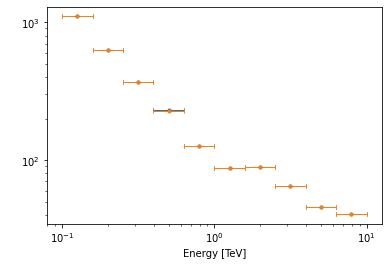

In [27]:
npred_spec = dataset.npred().get_spectrum(region)
npred_spec_1 = dataset_spec.npred()
npred_spec.plot()
npred_spec_1.plot()

In [49]:
dataset = MapDataset.read("$GAMMAPY_DATA/cta-1dc-gc/cta-1dc-gc.fits.gz")

pwl = PowerLawSpectralModel()
point = PointSpatialModel(lon_0="0 deg", lat_0="0 deg", frame="galactic")
model_1 = SkyModel(pwl, point, name="model-1")

pwl = PowerLawSpectralModel(amplitude="1e-11 TeV-1 cm-2 s-1")
gauss = GaussianSpatialModel(lon_0="0.3 deg", lat_0="0.3 deg", sigma="0.5 deg", frame="galactic")
model_2 = SkyModel(pwl, gauss, name="model-2")

dataset.models = [model_1, model_2]

npred = dataset.npred()

new_axis = MapAxis.from_energy_edges([0.1, 0.3, 1, 3, 10] * u.TeV)
npred_new = npred.resample_axis(axis=new_axis)

dataset_new = dataset.resample_energy_axis(new_axis)
npred_new_dataset = dataset_new.npred()

npred_new_dataset.get_spectrum().plot(label="A")
npred_new.get_spectrum().plot(label="B")
plt.legend()